# Binning loss

In [120]:
from iminuit import Minuit
import numpy as np
from scipy.stats import norm, uniform, poisson
from matplotlib import pyplot as plt
import progressbar

In [133]:
xrange = (0., 1.)
z = 0.2
mu = 0.5
sigma = 0.05

truth = (z, mu, sigma)

In [134]:
def unbinned(z, mu, sigma):
    """Unbinned likelihood"""
    probs = (1.0-z) / (xrange[1] - xrange[0]) + z * norm(mu, sigma).pdf(x)
    return -np.sum(np.log(probs))


def expected(z, mu, sigma):
    """Return expected counts per bin in a histogram"""
    nx = len(x)
    b = uniform(*xrange).cdf(xe)
    s = norm(mu, sigma).cdf(xe)
    m = (1-z) * b + z * s
    return len(x) * (m[1:] - m[:-1])


def binned(z, mu, sigma):
    """Binned likelihood for Poisson-distributed counts"""
    m = expected(z, mu, sigma)
    return np.sum(m - w * np.log(m))

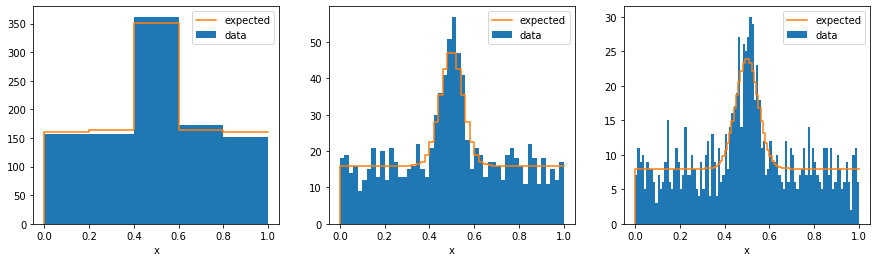

In [135]:
# check expected
np.random.seed(1)
s = norm(mu, sigma).rvs(int(z * 1000))
b = uniform(*xrange).rvs(1000 - len(s))
x = np.append(s, b)
assert len(x) == 1000

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for axi, bins in zip(ax, (5, 50, 100)):
    plt.sca(axi)
    w, xe, *_ = plt.hist(x, bins=bins, range=xrange, label="data")
    m = expected(*truth)
    plt.step(xe, np.append(0, m), label="expected")
    plt.legend()
    plt.xlabel("x")

In [212]:
np.random.seed(1)

bins = (5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 100)
ntot = 1000
nmc = 100

pars_unbinned = []
pars_binned = []
covs_unbinned = []
covs_binned = []

minuit_kwargs = {
    "z": 0.5, "mu": 0.5, "sigma": 0.05, "pedantic": False, "errordef": 0.5,
    "limit_z" : (0, 1), "limit_mu" : xrange, "limit_sigma" : (0, None)
}

for imc in progressbar.progressbar(range(nmc)):
    xs = norm(mu, sigma).rvs(int(z * ntot))
    xb = uniform(*xrange).rvs(ntot - len(xs))
    x = np.append(xs, xb)
    
    m_un = Minuit(unbinned, **minuit_kwargs)
    m_un.migrad()
    m_un.migrad()

    valid = m_un.get_fmin().is_valid
    if not valid:
        continue

    pars_b = []
    covs_b = []
    for b in bins:
        w, xe = np.histogram(x, bins=b, range=xrange)

        m = Minuit(binned, **minuit_kwargs)
        m.migrad()
        m.migrad()

        valid = m.get_fmin().is_valid
        if not valid:
            break

        pars_b.append(m.np_values())
        covs_b.append(m.np_covariance())

    if not valid:
        continue

    pars_unbinned.append(m_un.np_values())
    covs_unbinned.append(m_un.np_covariance())
    
    pars_binned.append(pars_b)
    covs_binned.append(covs_b)

pars_unbinned = np.array(pars_unbinned)
pars_binned = np.array(pars_binned)
covs_unbinned = np.array(covs_unbinned)
covs_binned = np.array(covs_binned)

100% (100 of 100) |######################| Elapsed Time: 0:03:22 Time:  0:03:22


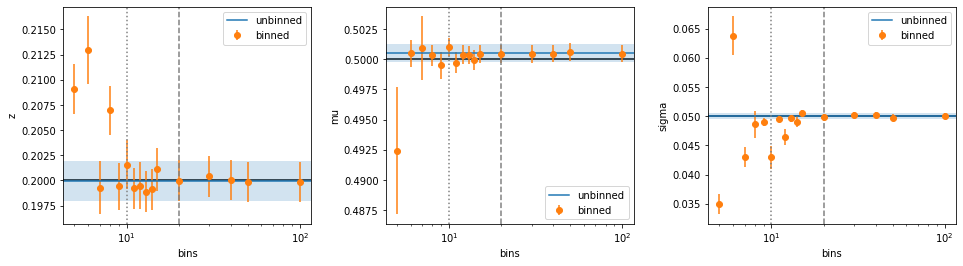

In [217]:
# bias
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
plt.subplots_adjust(wspace=0.3)
for ipar, name in enumerate(("z", "mu", "sigma")):
    plt.sca(ax[ipar])
    y = pars_unbinned[:, ipar]
    m = np.mean(y)
    s = np.std(y) / n ** 0.5
    n = len(pars_unbinned)
    plt.axhline(m, label="unbinned")
    plt.axhspan(m-s, m+s, alpha=0.2)
    y = pars_binned[:, :, ipar]
    m = np.mean(y, axis=0)
    s = np.std(y, axis=0) / n ** 0.5
    plt.errorbar(bins, m, s, fmt="o", color="C1", label="binned")
    plt.legend()
    plt.xlabel("bins")
    plt.semilogx()
    plt.ylabel(name)
    plt.axvline((xrange[1] - xrange[0])/sigma, ls="--", color="0.5")
    plt.axvline((xrange[1] - xrange[0])/(2 * sigma), ls=":", color="0.5")
    plt.axhline(truth[ipar], color="k", zorder=0)

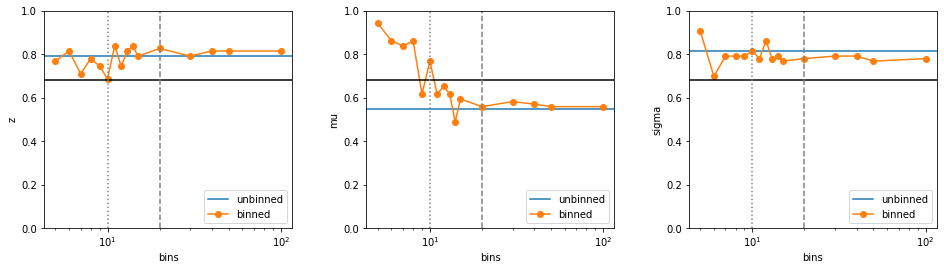

In [218]:
# coverage probability
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
plt.subplots_adjust(wspace=0.3)
for ipar, name in enumerate(("z", "mu", "sigma")):
    plt.sca(ax[ipar])
    y = pars_unbinned[:, ipar]
    dy = covs_unbinned[:, ipar, ipar] ** 0.5
    prob = np.mean((truth[ipar] < y + dy) & (truth[ipar] > y - dy))
    plt.axhline(prob, label="unbinned")
    y = pars_binned[:, :, ipar]
    dy = covs_binned[:, :, ipar, ipar] ** 0.5
    prob = np.mean((truth[ipar] < y + dy) & (truth[ipar] > y - dy), axis=0)
    plt.plot(bins, prob, "o-", color="C1", label="binned")
    plt.ylim(0, 1)
    plt.xlabel("bins")
    plt.semilogx()
    plt.ylabel(name)
    plt.axhline(0.68, ls="-", color="k")
    plt.axvline((xrange[1] - xrange[0])/sigma, ls="--", color="0.5")
    plt.axvline((xrange[1] - xrange[0])/(2 * sigma), ls=":", color="0.5")
    plt.legend(loc="lower right")